#   Bibliotecas

- Versões das bibliotecas no README

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes


In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [3]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#import de funções do script de pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [5]:
import tensorflow as tf

In [6]:
# Modelo a ser testado
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14213384562929486210
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2252026676
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4456145180758486111
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [8]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [9]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [10]:
train,test = pre_processamento(train,test)

#   Pré-processamento 

In [11]:
train = textcolumns_junct(train) #Função pra juntar as colunas de texto em uma só coluna

In [12]:
#Convertendo tudo para string

train["item_description"] = train["item_description"].astype(str)

In [13]:
train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.

In [14]:
train["item_description"] = train["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [15]:
train["item_description"] = train["item_description"].apply(lambda x: stemming(x))

In [16]:
train["item_description"]=[" ".join(review) for review in train["item_description"].values]

In [17]:
train["item_description"]

0              mlb cincinnati red shirt size xl descript yet
1          razer blackwidow chroma keyboard razer keyboar...
2          ava viv blous target ador top hint lace key ho...
3          leather hors statu new tag . leather hors . re...
4                 24k gold plate rose complet certif authent
                                 ...                        
1482530    free peopl inspir dress free peopl lace say si...
1482531    littl mermaid handmad dress disney littl merma...
1482532    21 day fix contain eat plan use twice still gr...
1482533    world market lantern 2 one see 2 red 2 orang 2...
1482534    brand new lux de vill wallet new tag red spark...
Name: item_description, Length: 1481661, dtype: object

In [18]:
train.shape

(1481661, 11)

#   Split

In [19]:
train1 = train.drop(train[~((train['price'] > 0) & (train['price'] <= 250))].index)

In [20]:
train1.shape

(1475534, 11)

In [21]:
X = train1.drop("price", axis = 1)
y = train1["price"]

In [22]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de teste de possíveis vazamentos e das mudanças de hyperparametros. 

X1, Xtest, y1, ytest = train_test_split(X, y, test_size=0.1, random_state=10) #Divisão em 90/10

In [23]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=10) #Divisão em 80/20

<AxesSubplot: >

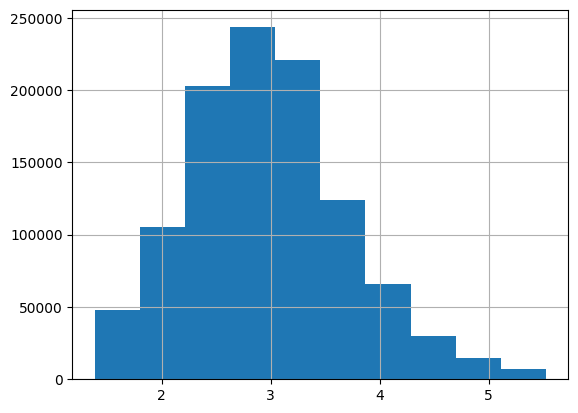

In [24]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

In [25]:
print(Xtrain.shape,ytrain.shape) 
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(1062384, 10) (1062384,)
(265596, 10) (265596,)
(147554, 10) (147554,)


# Transformadores

In [26]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=25000) #vetorização, com stop word. 

In [27]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<1062384x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 26265778 stored elements in Compressed Sparse Row format>

In [28]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<265596x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 6566046 stored elements in Compressed Sparse Row format>

In [29]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<1062384x985 sparse matrix of type '<class 'numpy.float64'>'
	with 5311920 stored elements in Compressed Sparse Row format>

In [30]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<265596x985 sparse matrix of type '<class 'numpy.float64'>'
	with 1327960 stored elements in Compressed Sparse Row format>

In [31]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ], format='csr') 
x_train

<1062384x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 31577698 stored elements in Compressed Sparse Row format>

In [32]:
x_val = hstack([
                 (vec_val),
                 (ohe_val)
                             ], format='csr') 
x_val

<265596x25985 sparse matrix of type '<class 'numpy.float64'>'
	with 7894006 stored elements in Compressed Sparse Row format>

# Modelo

In [33]:
#del model  # for avoid any trace on aigen
tf.keras.backend.clear_session()  # removing session, it will instance another

In [34]:
input = Input(shape=(x_train.shape[-1]), sparse=True, name='sparse')
dense3 = Dense(2500, activation="relu") (input)
dense4 = Dense(1250, activation="relu") (dense3)
dense5 = Dense(600, activation="relu") (dense4)
dense6 = Dense(300, activation="relu") (dense5)
dense7 = Dense(100, activation="relu") (dense6)

out = Dense(1) (dense7)

model = Model(inputs = input, outputs = out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse (InputLayer)         [(None, 25985)]           0         
                                                                 
 dense (Dense)               (None, 2500)              64965000  
                                                                 
 dense_1 (Dense)             (None, 1250)              3126250   
                                                                 
 dense_2 (Dense)             (None, 600)               750600    
                                                                 
 dense_3 (Dense)             (None, 300)               180300    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101   

In [35]:
model.compile(loss="mean_squared_error", 
              metrics=['mean_squared_error', RootMeanSquaredError()], 
              optimizer = 'Adam')



In [36]:
x_train.sort_indices()

In [37]:

history =  model.fit(x_train,
                     ytrain.values, 
                     batch_size=1024,
                     epochs=20, 
                     verbose=True)

Epoch 1/20


c:\Users\angel\Desktop\Data science\venv\blue_bootcamp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2500), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


1038/1038 [==============================] - 117s 107ms/step - loss: 0.2783 - mean_squared_error: 0.2783 - root_mean_squared_error: 0.5275
Epoch 2/20
1038/1038 [==============================] - 115s 108ms/step - loss: 0.1747 - mean_squared_error: 0.1747 - root_mean_squared_error: 0.4180
Epoch 3/20
1038/1038 [==============================] - 114s 107ms/step - loss: 0.1234 - mean_squared_error: 0.1234 - root_mean_squared_error: 0.3512
Epoch 4/20
1038/1038 [==============================] - 116s 109ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - root_mean_squared_error: 0.2804
Epoch 5/20
1038/1038 [==============================] - 115s 107ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - root_mean_squared_error: 0.2291
Epoch 6/20
1038/1038 [==============================] - 113s 106ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - root_mean_squared_error: 0.1978
Epoch 7/20
1038/1038 [==============================] - 115s 108ms/step - loss: 0.0316 - mean_squared_error: 0.

In [38]:
x_val.sort_indices()

In [39]:
ypredict = model.predict(x_val)

8300/8300 [==============================] - 34s 4ms/step


In [40]:
ypredict = np.expm1(ypredict)


#   Resultado

- predict validação

In [41]:
print('MAE: $ %.2f' %  mean_absolute_error(yval,ypredict))
print('RMSE:  $ %.2f' %  (mean_squared_error(yval,ypredict)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))


MAE: $ 9.11
RMSE:  $ 17.33
RMSLE: 0.201505
